# Gammapy Maps

![Gammapy Maps Illustration](images/gammapy_maps.png)

## Introduction
The [gammapy.maps](http://docs.gammapy.org/dev/maps/index.html) submodule contains classes for representing **sky images** with an **arbitrary number of non-spatial dimensions** such as energy, time, event class or any possible user-defined dimension (illustrated in the image above). The main `Map` data structure features a **uniform API** for [WCS](https://fits.gsfc.nasa.gov/fits_wcs.html) as well as [HEALPix](https://en.wikipedia.org/wiki/HEALPix) based images. The API also generalizes simple image based operations such as smoothing, interpolation and reprojection to the arbitrary extra dimensions and makes working with (2 + N)-dimensional hypercubes **as easy as working with a simple 2D image**. Further information is also provided on the [gammpy.maps docs page](http://docs.gammapy.org/dev/maps/index.html).


In the following introduction we will **learn all the basics** of working with WCS based maps. HEALPix based maps will be covered in a future tutorial. We will cover the following topics in order:

1. Creating WCS Maps
1. Accessing and Modifying Data
1. Reading and Writing with FITS I/O
1. Visualizing and Plotting Maps
1. Reprojecting, Interpolating and Miscellaneous

Make sure you have worked through he [First Steps with Gammapy](fits_steps.ipynb) and [Astropy Introduction](astropy_introduction.ipynb) notebooks, because a solid knowledge about working with `SkyCoords` and `Quantity` objects as well as [Numpy](http://www.numpy.org/) is required for this tutorial.

**Note:** This notebook is rather lengthy, but getting to know the `Map` data structure in detail is **essential for working with Gammapy** and will allow you to fulfill **complex analysis tasks with very few and simple code** in future!

## 0. Setup
--------------

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.maps import Map, MapAxis, WcsGeom

## 1. Creating Maps
-------------------------
### 1.1 Using Factory Methods

Maps are most easily created using the `Map.create()` factory method:

In [3]:
m_allsky = Map.create()

Calling `Map.create()` without any further arguments creates by default an allsky WCS map using a CAR projection, ICRS coordinates and a pixel size of 1 deg. This can be easily checked by printing the `.geom` attribute of the map:

In [4]:
print(m_allsky.geom)

WcsGeom

	axes       : lon, lat
	shape      : (3600, 1800)
	ndim       : 2
	coordsys   : CEL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 360.0 x 180.0 deg



The `.geom` attribute is a `MapGeom` object, that defines the basic geometry of the map, such as size of the pixels, width and height of the image, coordinate system etc., but we will learn more about this object later.

Besides the `.geom` attribute the map has also a `.data` attribute, which is just a plain `numpy.ndarray` and stores the data associated with this map:

In [5]:
m_allsky.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

By default maps are filled with zeros.

Here is a second example that creates a WCS map centered on the Galactic center and now uses Galactic coordinates:

In [6]:
skydir = SkyCoord(0, 0, frame='galactic', unit='deg')
m_gc = Map.create(binsz=0.02, width=(10, 5), skydir=skydir, coordsys='GAL', proj='TAN')
print(m_gc.geom)

WcsGeom

	axes       : lon, lat
	shape      : (500, 250)
	ndim       : 2
	coordsys   : GAL
	projection : TAN
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 5.0 deg



In addition we have defined a TAN projection, a pixel size of `0.02` deg and a width of the map of `10 deg x 5 deg`. The `width` argument also takes scalar value instead of a tuple, which is interpreted as both the width and height of the map, so that a quadratic map is created.

### 1.2 Creating from a Map Geometry

As we have seen in the first examples, the `Map` object couples the data (stored as a `numpy.ndarray`) with a `MapGeom` object. The `MapGeom` object can be seen as a generalization of an `astropy.wcs.WCS` object, providing the information on how the data maps to physical coordinate systems. In some cases e.g. when creating many maps with the same WCS geometry it can be advantegeous to first create the map geometry independent of the map object itsself: 

In [7]:
wcs_geom = WcsGeom.create(binsz=0.02, width=(10, 5), skydir=(0, 0), coordsys='GAL')

And then create the map objects from the `wcs_geom` geometry specification:

In [8]:
maps = {}

for name in ['counts', 'background']:
    maps[name] = Map.from_geom(wcs_geom)

The `MapGeom` object also has a few helpful methods. E.g. we can check whether a given position on the sky is contained in the map geometry:

In [9]:
# define the position of the Galactic center and anti-center
positions = SkyCoord([0, 180], [0, 0], frame='galactic', unit='deg')
wcs_geom.contains(positions)

array([ True, False])

Or get the image center of the map:

In [10]:
wcs_geom.center_skydir

<SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>

Or we can also retrieve the solid angle per pixel of the map:

In [11]:
wcs_geom.solid_angle()

<Quantity [[1.21730997e-07, 1.21730997e-07, 1.21730997e-07, ...,
            1.21730997e-07, 1.21730997e-07, 1.21730997e-07],
           [1.21732844e-07, 1.21732844e-07, 1.21732844e-07, ...,
            1.21732844e-07, 1.21732844e-07, 1.21732844e-07],
           [1.21734677e-07, 1.21734677e-07, 1.21734677e-07, ...,
            1.21734677e-07, 1.21734677e-07, 1.21734677e-07],
           ...,
           [1.21736496e-07, 1.21736496e-07, 1.21736496e-07, ...,
            1.21736496e-07, 1.21736496e-07, 1.21736496e-07],
           [1.21734677e-07, 1.21734677e-07, 1.21734677e-07, ...,
            1.21734677e-07, 1.21734677e-07, 1.21734677e-07],
           [1.21732844e-07, 1.21732844e-07, 1.21732844e-07, ...,
            1.21732844e-07, 1.21732844e-07, 1.21732844e-07]] sr>

### 1.3 Adding Non-Spatial Axes

In many analysis scenarios we would like to add extra dimension to the maps to study e.g. energy or time dependency of the data. Those non-spatial dimensions are handled with the `MapAxis` object. Let us first define an energy axis, with 4 bins:

In [12]:
energy_axis = MapAxis.from_bounds(1, 100, nbin=4, unit='TeV', name='energy', interp='log')
print(energy_axis)

MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 4         
	node type  : edges     
	edges min  : 1.0e+00 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       



Where `interp='log'` specifies that a logarithmic spacing is used between the bins, equivalent to `np.logspace(0, 2, 4)`. This `MapAxis` object we can now pass to `Map.create()` using the `axes=` argument:

In [13]:
m_cube = Map.create(binsz=0.02, width=(10, 5), coordsys='GAL', axes=[energy_axis])
print(m_cube.geom)

WcsGeom

	axes       : lon, lat, energy
	shape      : (500, 250, 4)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 5.0 deg



Now we see that besides `lon` and `lat` the map has an additional axes named `energy` with 4 bins. The total dimension of the map is now `ndim=3`.

We can also add further axes by passing a list of `MapAxis` objects. To demonstrate this we create a time axis with
linearly spaced bins and pass both axes to `Map.create()`:

In [14]:
time_axis = MapAxis.from_bounds(0, 24, nbin=24, unit='hour', name='time', interp='lin')

m_4d = Map.create(binsz=0.02, width=(10, 5), coordsys='GAL', axes=[energy_axis, time_axis])
print(m_4d.geom)

WcsGeom

	axes       : lon, lat, energy, time
	shape      : (500, 250, 4, 24)
	ndim       : 4
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 5.0 deg



The `MapAxis` object internally stores the coordinates or "position values" associated with every map axis bin or "node". We distinguish between two node types: `edges` and `center`. The node type `edges`(which is also the default) specifies that the data associated with this axis is integrated between the edges of the bin (e.g. counts data). The node type `center` specifies that the data is given at the center of the bin (e.g. exposure or differential fluxes).

The edges of the bins can be checked with `.edges` attribute:

In [15]:
energy_axis.edges

array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        ])

The numbers are given in the units we specified above, which can be checked again with:

In [16]:
energy_axis.unit

Unit("TeV")

The centers of the axis bins can be checked with the `.center` attribute:

In [17]:
energy_axis.center

array([ 1.77827941,  5.62341325, 17.7827941 , 56.23413252])

## 2. Accessing and Modifying Map Data
----------------------------------------------------

### 2.1 Accessing Map Data Values

All map objects have a set of accessor methods, which can be used to access or update the contents of the map irrespective of its underlying representation. Those accessor methods accept as their first argument a coordinate `tuple` containing scalars, `list`, or `numpy.ndarray` with one tuple element for each dimension. Some methods additionally accept a `dict` or `MapCoord` argument, of which both allow to assign coordinates by axis name.

Let us first begin with the `.get_by_idx()` method, that accepts a tuple of indices. The order of the indices corresponds to the axis order of the map: 

In [18]:
m_gc.get_by_idx((50, 30))

array([0.], dtype=float32)

**Important:** Gammapy uses a reversed index order in the map API with the longitude axes first. To achieve the same by directly indexing into the numpy array we have to call:  

In [19]:
m_gc.data[([30], [50])]

array([0.], dtype=float32)

To check the order of the axes you can always print the `.geom` attribute:

In [20]:
print(m_gc.geom)

WcsGeom

	axes       : lon, lat
	shape      : (500, 250)
	ndim       : 2
	coordsys   : GAL
	projection : TAN
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 5.0 deg



To access values directly by sky coordinates we can use the `.get_by_coord()` method. This time we pass in a `dict`, specifying the axes names corresponding to the given coordinates:

In [21]:
m_gc.get_by_coord({'lon': [0, 180], 'lat': [0, 0]})

array([ 0., nan], dtype=float32)

The units of the coordinates are assumed to be in degrees. If the coordinates do not correspond to the exact pixel center, the value of the nearest pixel center will be returned. For positions outside the map geometry `np.nan` is returned.

The coordinate or idx arrays follow normal [Numpy broadcasting rules](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html). So the following works as expected:



In [22]:
lons = np.linspace(-4, 4, 10) 
m_gc.get_by_coord({'lon': lons, 'lat': 0})

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Or as an even more advanced example, we can provide `lats` as column vector and broadcasting to a 2D result array will be applied:

In [23]:
lons = np.linspace(-4, 4, 8)
lats = np.linspace(-4, 4, 8).reshape(-1, 1)
m_gc.get_by_coord({'lon': lons, 'lat': lats})

array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32)

### 2.2 Modifying Map Data Values

To modify and set map data values the `Map` object features as well a `.set_by_idx()` method: 


In [24]:
m_cube.set_by_idx(idx=(10, 20, 3), vals=42)

In [25]:
m_cube.get_by_idx((10, 20, 3))

array([42.], dtype=float32)

Of course there is also a `.set_by_coord()` method, which allows to set map data values in physical coordinates. 

In [26]:
m_cube.set_by_coord({'lon': 0, 'lat': 0, 'energy': 2 * u.TeV}, vals=42)

Again the `lon` and `lat` values are assumed to be given in degrees. For the energy axis, the unit is the one specified on the axis (use `m_cube.geom.axes[0].unit` to check if needed...)

All `.xxx_by_coord()` methods accept `SkyCoord` objects as well. In this case we have to use the `skycoord` keyword instead of `lon` and `lat`:

In [27]:
skycoords = SkyCoord([1.2, 3.4], [-0.5, 1.1], frame='galactic', unit='deg')
m_cube.set_by_coord({'skycoord': skycoords, 'energy': 2 * u.TeV}, vals=42)

### 2.3 Indexing and Slicing Sub-Maps

When you have worked with Numpy arrays in the past you are probably familiar with the concept of indexing and slicing
into data arrays. To support slicing of non-spatial axes of `Map` objects, the `Map` object has a `.slice_by_idx()` method, which allows to extract sub-maps from a larger map.

The following example demonstrates how to get the map at the energy bin number 3:  

In [28]:
m_sub = m_cube.slice_by_idx({'energy': 3})
print(m_sub)

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (500, 250)
	ndim  : 2
	unit  : '' 
	dtype : float32 



Note that the returned object is again a `Map` with updated axes information. In this case, because we extracted only a single image, the energy axes is dropped from the map.

To extract a sub-cube with a sliced energy axes we can use a normal `slice()` object:

In [29]:
m_sub = m_cube.slice_by_idx({'energy': slice(1, 3)})
print(m_sub)

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (500, 250, 2)
	ndim  : 3
	unit  : '' 
	dtype : float32 



Note that the returned object is also a `Map` object, but this time with updated energy axis specification.

Slicing of multiple dimensions is supported by adding further entries to the dict passed to `.slice_by_idx()`

In [30]:
m_sub = m_4d.slice_by_idx({'energy': slice(1, 3), 'time': slice(4, 10)})
print(m_sub)

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy, time
	shape : (500, 250, 2, 6)
	ndim  : 4
	unit  : '' 
	dtype : float32 



For convenience there is also a `.get_image_by_coord()` method which allows to access image planes at given non-spatial physical coordinates. This method also supports `Quantity` objects:

In [31]:
image = m_4d.get_image_by_coord({'energy': 4 * u.TeV, 'time': 5 * u.h})
print(image.geom)

WcsGeom

	axes       : lon, lat
	shape      : (500, 250)
	ndim       : 2
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 5.0 deg



## 3. Reading and Writing with FITS I/O
--------------------------------------------------




## 4. Visualizing and Plotting Maps
---------------------------------------------

### 4.1 Plotting 

For debugging and inspecting the map data it is useful to plot ot visualize the images planes contained in the map. 

In [32]:
filename = '$GAMMAPY_EXTRA/datasets/fermi_2fhl/fermi_2fhl_gc.fits.gz'
m_2fhl_gc = Map.read(filename, hdu='counts')

After reading the map we can now plot it on the screen by calling the `.plot()` method:

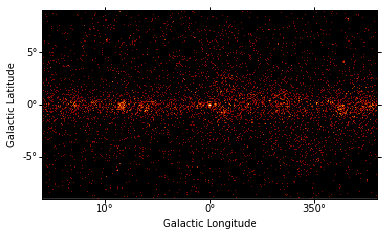

In [33]:
m_2fhl_gc.plot(stretch='sqrt');

We can easily improve the plot by calling `Map.smooth()` first and providing additional arguments to `.plot()` methods. Most of them are passed further to [plt.imshow()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html):

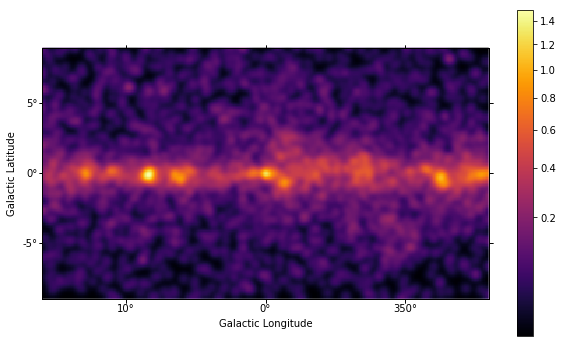

In [34]:
plt.figure(figsize=(10, 6))
smoothed = m_2fhl_gc.smooth(radius=0.5 * u.deg, kernel='gauss')
smoothed.plot(stretch='sqrt', cmap='inferno', add_cbar=True);

### 4.2 Interactive Plotting 

For maps with non-spatial dimensions the `Map` object features an interactive plotting method, that works in jupyter notebooks (**Note:** it requires the package `ipywidgets` to be installed). We first read a small example cutout from the Fermi Galactic diffuse model and display the data cube by calling `.plot_interactive()`:

In [35]:
filename = '$GAMMAPY_EXTRA/datasets/fermi_3fhl/gll_iem_v06_cutout.fits'
m_iem_gc = Map.read(filename)

rc_params = {'figure.figsize': (12, 6), 'font.size': 14}
m_iem_gc.plot_interactive(add_cbar=True, stretch='linear', rc_params=rc_params)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

Now you can use the interactive slider to select an energy range and the corresponding image is diplayed on the screen. You can also use the radio buttons to select your preferred image stretching. We have passed additional keywords using the `rc_params` argument to improve the figure and font size. Those keywords are directly passed to the [plt.rc_context()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.rc_context.html) context manager.

## 5. Reprojecting, Interpolating and Miscellaneous
------------------------------------------------------------------

Now we proceed to a few advanced topics.


### 5.1 Reprojecting to Different  Map Geometries